In [1]:
import os
import healpy as h
import collections
from modules.calc_EB_rec_noise.fast_calc_eb_rec_noise import calc_eb_rec_noise
from modules.calc_TB_rec_noise.fast_calc_tb_rec_noise import calc_tb_rec_noise
from modules import eb_rec
from modules import tb_rec

from astropy.io import fits
figpath="./planck143/"

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
ensure_dir(figpath)

# jpegpath=figpath + "/jpeg/" ; ensure_dir(jpegpath)
datapath=figpath + "/data/" ; ensure_dir(datapath)

%pylab notebook

def return_Nl(fwhm,noise_rms,lmax):
    ell=np.arange(lmax+1)
    noise_rms=noise_rms*(1./60.)*(np.pi/180.)
    thetab=((fwhm/60.)*np.pi/180.)/np.sqrt(8.*np.log(2))
    Bl=exp(thetab**2 *(ell*(ell+1))/2)
    return ell,noise_rms**2. * Bl**2.

Populating the interactive namespace from numpy and matplotlib


# Theory power spectra

In [79]:
nside=1024
lmax=512
lpad=200
lmin=2
Lmax=512

# clthry=np.loadtxt("../T2P_leakage/planck_2015_cmb/planck_2015_cmb_totCls.dat")
# clthry=np.loadtxt("../T2P_leakage/planck_2015_cmb/planck_2015_cmb_lensedtotCls.dat")

# maxell=3500
# ell=clthry[:maxell+1,0] ; fl=ell*(ell+1)/(2.*pi)
# cltt=clthry[:maxell+1,1]/fl ; cltt=append([0.,0.],cltt)
# clee=clthry[:maxell+1,2]/fl ; clee=append([0.,0.],clee)
# clbb=clthry[:maxell+1,3]/fl ; clbb=append([0.,0.],clbb)
# clte=clthry[:maxell+1,4]/fl ; clte=append([0.,0.],clte)
# ell=append([0.,1,],ell) ; fl=ell*(ell+1)/(2.*pi)
# clthr=[cltt,clee,clbb,clte]

clthry=np.loadtxt("./planck_cmb_cl/cmb_cl.txt")

maxell=3500
ell=clthry[:maxell+1,0] ; fl=ell*(ell+1)/(2.*pi)
cltt=clthry[:maxell+1,1]/fl ; cltt=append([0.,0.],cltt)
clte=clthry[:maxell+1,2]/fl ; clte=append([0.,0.],clte)
clee=clthry[:maxell+1,3]/fl ; clee=append([0.,0.],clee)
clbb=clthry[:maxell+1,4]/fl ; clbb=append([0.,0.],clbb)
ell=append([0.,1,],ell) ; fl=ell*(ell+1)/(2.*pi)
clthr=[cltt,clee,clbb,clte]

# Mask and beam

In [3]:
ell=np.arange(lmax+1)
beamfile="/Users/adityarotti/Documents/Work/Data/Planck/maps/HFI_RIMO_Beams-075pc_R2.00.fits"
f=fits.open(beamfile)
bl143=f[4].data[0][0][:lmax+lpad+1]
bp=np.ones_like(bl143)
f.close()

maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
# maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits"
mask52=h.read_map(maskname,2,dtype=np.float64,verbose=False)
mask52=h.ud_grade(mask52,nside)
fsky52=sum(mask52)/size(mask52)
mask62=h.read_map(maskname,3,dtype=np.float64,verbose=False)
mask62=h.ud_grade(mask62,nside)
fsky62=sum(mask62)/size(mask62)
mask72=h.read_map(maskname,4,dtype=np.float64,verbose=False)
mask72=h.ud_grade(mask72,nside)
fsky72=sum(mask72)/size(mask72)

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


<IPython.core.display.Javascript object>


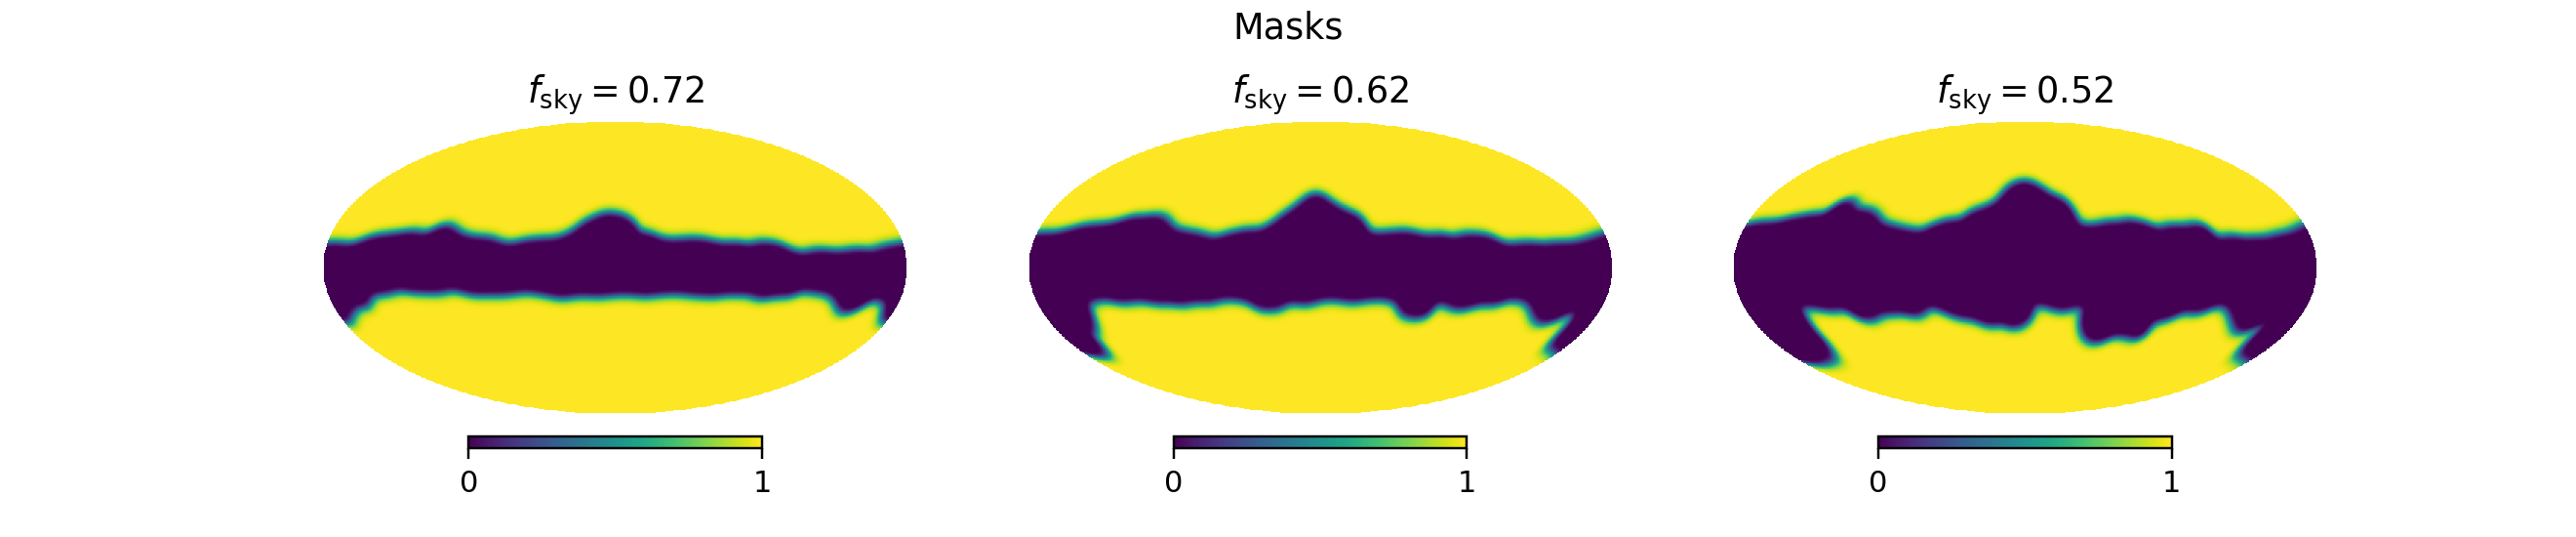

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [4]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=[12,2.5])
axes(ax1)
h.mollview(mask72,title=r"$f_{\rm sky}=$" + str(round(fsky72,2)),hold=True)
axes(ax2)
h.mollview(mask62,title=r"$f_{\rm sky}=$" + str(round(fsky62,2)),hold=True)
axes(ax3)
h.mollview(mask52,title=r"$f_{\rm sky}=$" + str(round(fsky52,2)),hold=True)
suptitle(r"Masks")
figname=figpath + "masks.pdf"
savefig(figname,bbox_inches="tight",dpi=300)

In [12]:
fwhm143=7.22 #arcminutes
blthry=h.gauss_beam(fwhm=(fwhm143/60.)*np.pi/180.)
Trms=0.55 # uK-deg
Prms=1.17 # uK-deg

ell,Nl_T=return_Nl(fwhm143,Trms*60.,lmax)
ell,Nl_P=return_Nl(fwhm143,Prms*60.,lmax)
Nl_thry=[Nl_T,Nl_P,Nl_P,Nl_P*0.]

# Read in data

In [6]:
fname143="/Users/adityarotti/Documents/Work/Data/Planck/maps/HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits"
tqu=h.read_map(fname143,(0,1,2),dtype=np.float64,verbose=False)*1e6

In [7]:
alm=h.map2alm(tqu,pol=True,lmax=lmax+lpad)
alm[0]=h.almxfl(alm[0],fl=1./bl143)
alm[1]=h.almxfl(alm[1],fl=1./bl143)
alm[2]=h.almxfl(alm[2],fl=1./bl143)
dec_tqu=h.alm2map(alm,pol=True,nside=nside)
alm52=h.map2alm(dec_tqu*mask52,pol=True,lmax=lmax)
alm62=h.map2alm(dec_tqu*mask62,pol=True,lmax=lmax)
alm72=h.map2alm(dec_tqu*mask72,pol=True,lmax=lmax)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [9]:
lmax

1536

## Spectra plots

<IPython.core.display.Javascript object>


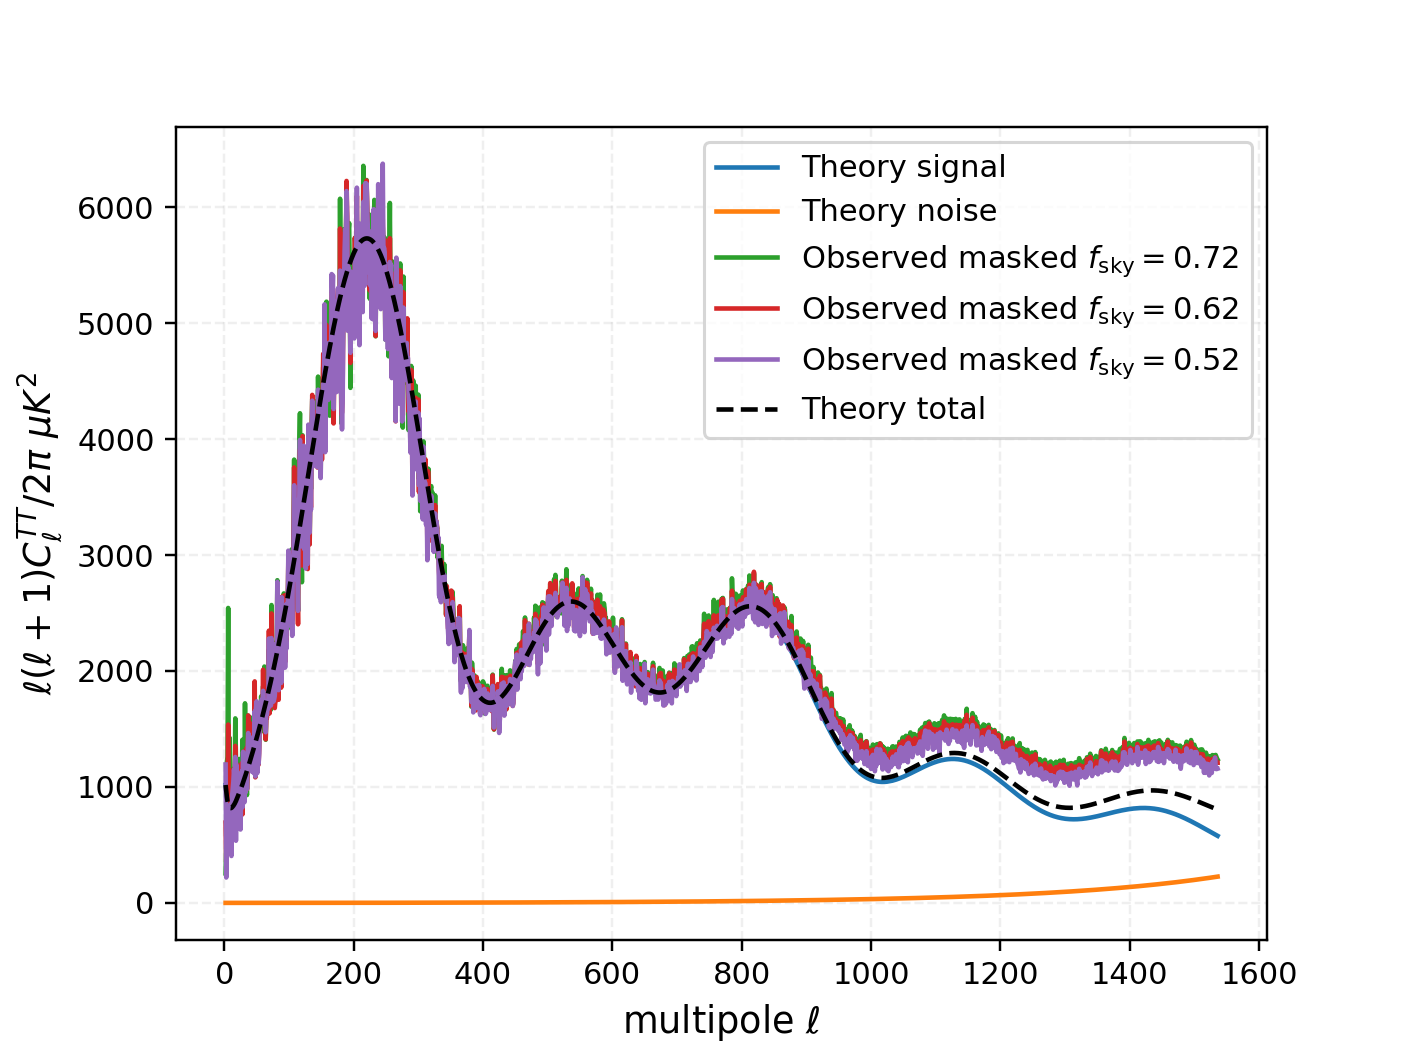

<IPython.core.display.Javascript object>


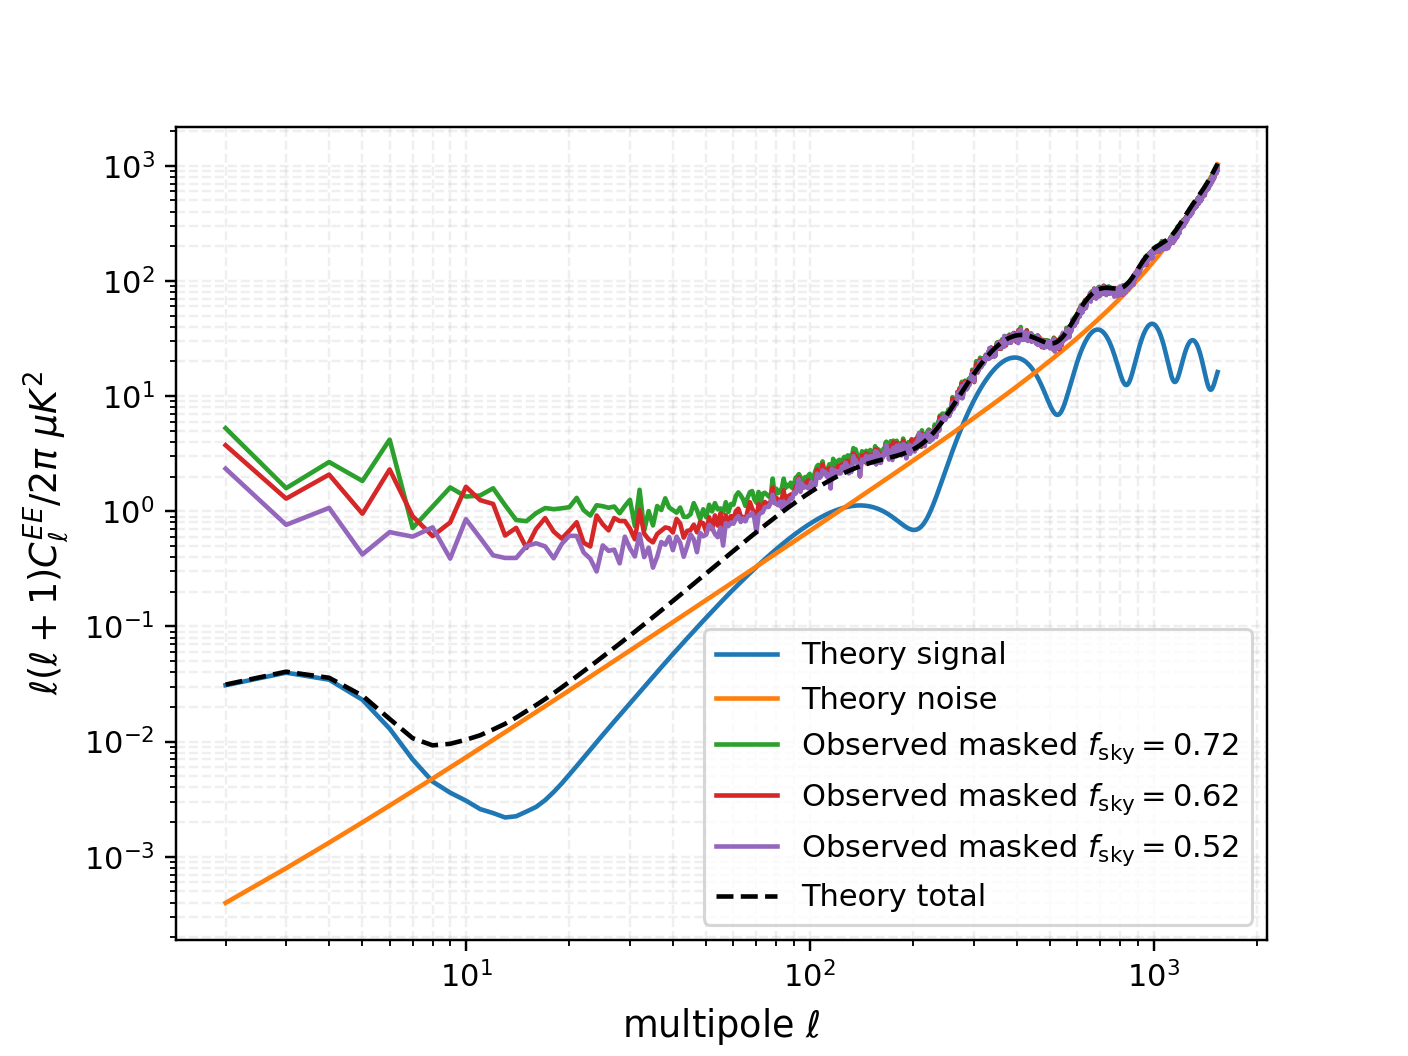

<IPython.core.display.Javascript object>


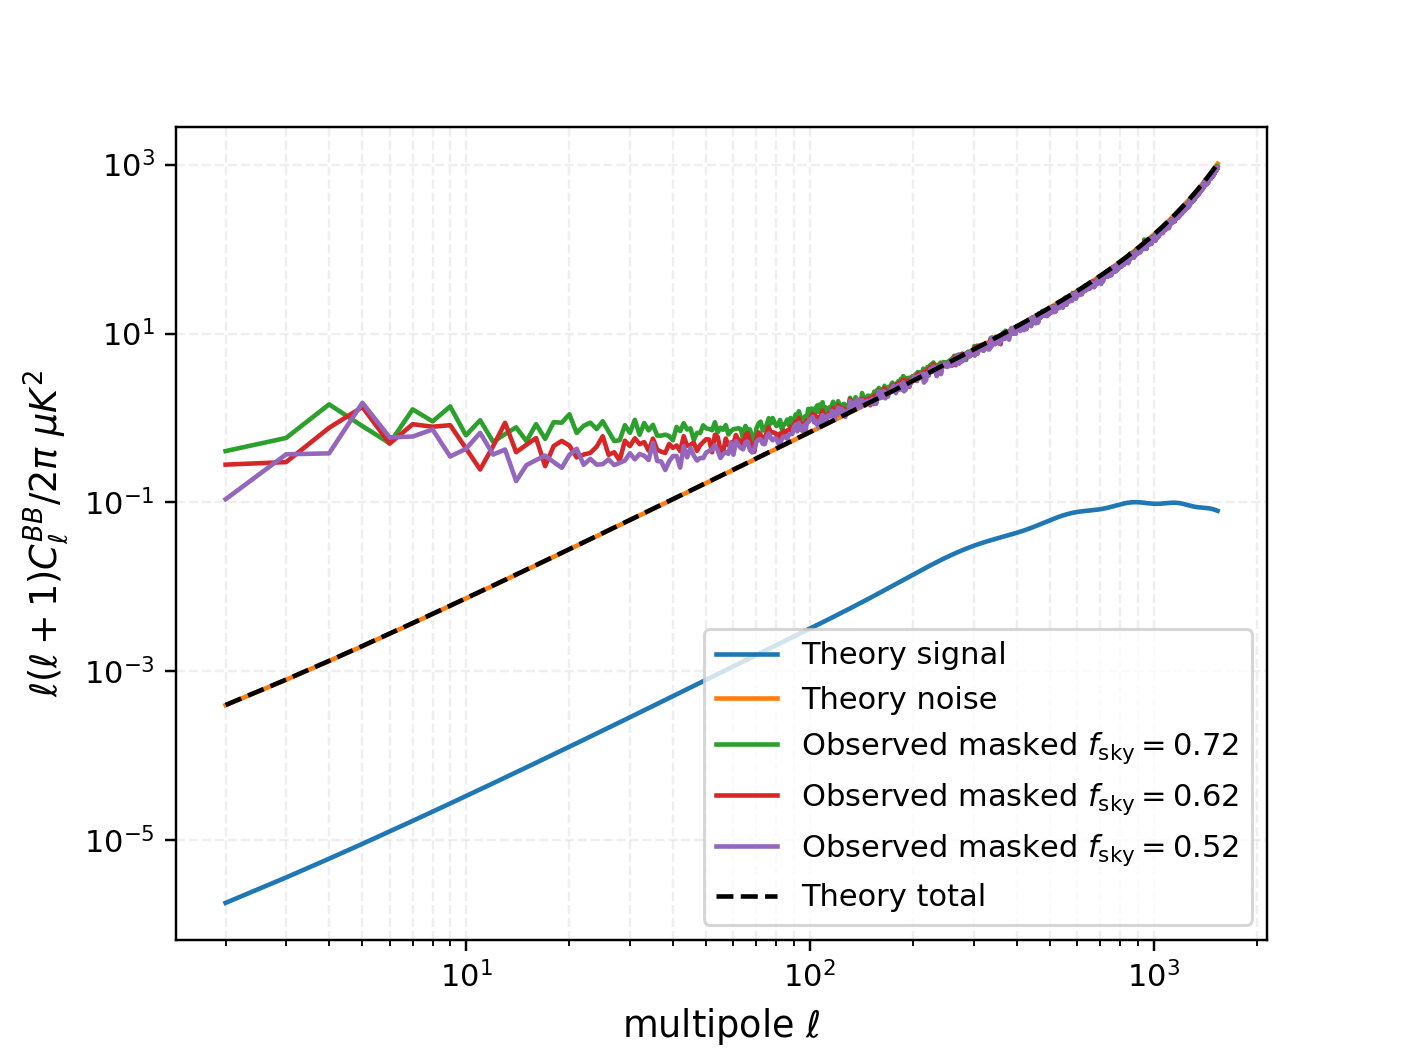

<IPython.core.display.Javascript object>


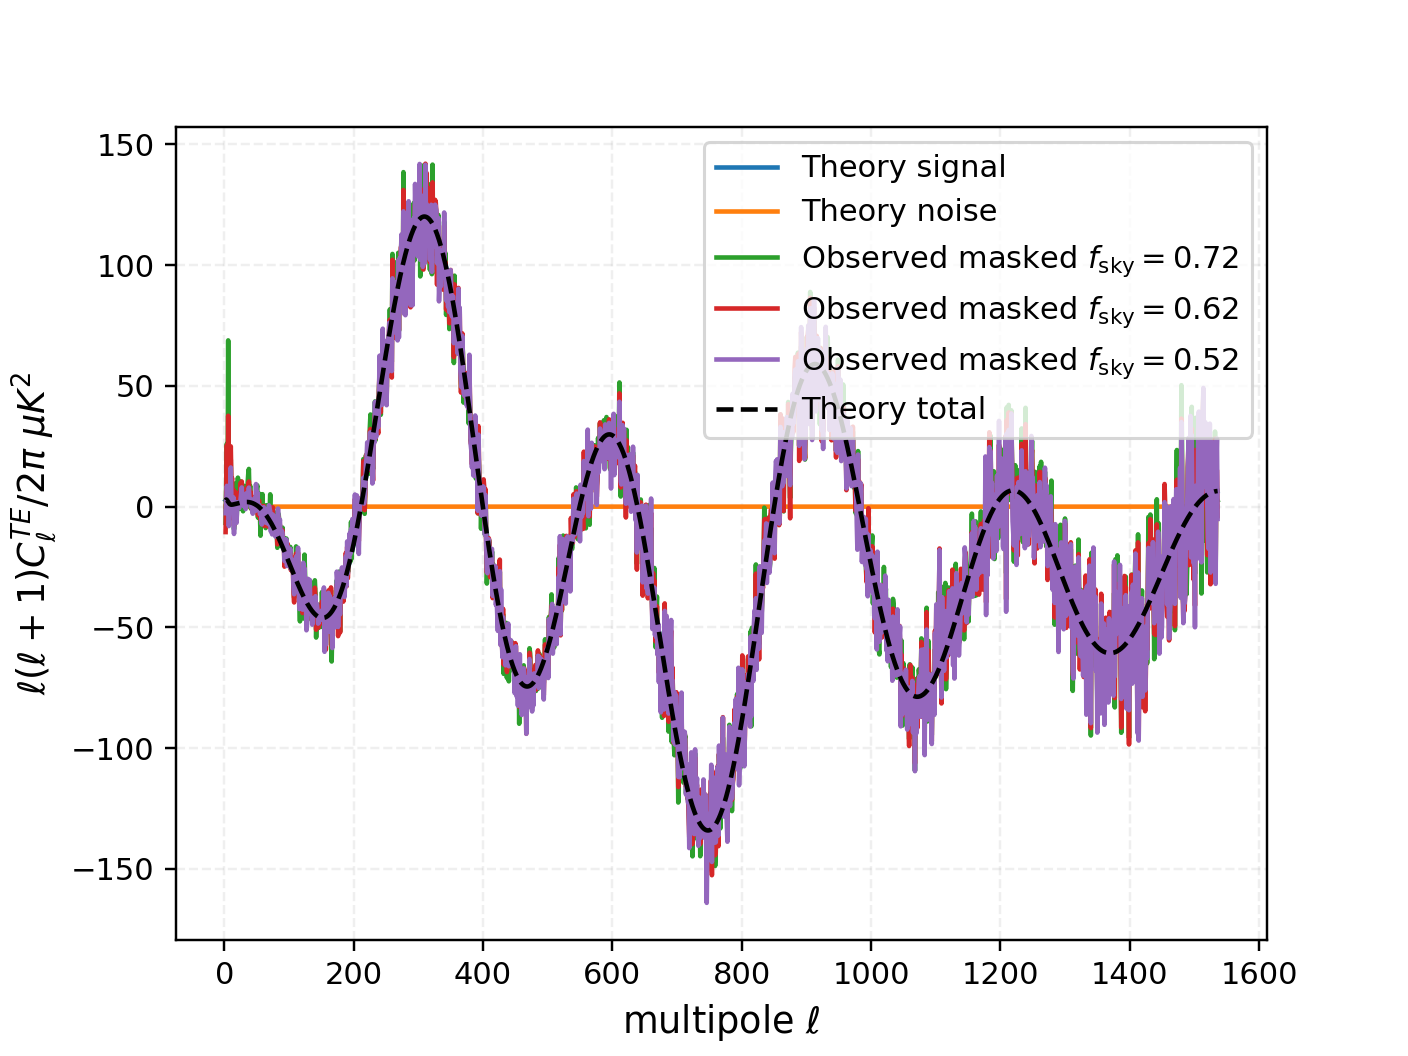

In [13]:
clobs=h.alm2cl(alm)
clm52=h.alm2cl(alm52)/fsky52
clm62=h.alm2cl(alm62)/fsky62
clm72=h.alm2cl(alm72)/fsky72

ell=np.arange(lmax+1)
fl=ell*(ell+1)/(2.*pi)

cmp_list=["TT","EE","BB","TE"]

for idx in range(4):
    figure()
    plot(ell[2:],fl[2:]*clthr[idx][2:lmax+1],label="Theory signal")
    plot(ell[2:],fl[2:]*Nl_thry[idx][2:],label="Theory noise")
#     plot(ell[2:],fl[2:]*clobs[idx][2:],label="Observed")
    plot(ell[2:],fl[2:]*clm72[idx][2:],label=r"Observed masked $f_{\rm sky}=$" +str(round(fsky72,2)))
    plot(ell[2:],fl[2:]*clm62[idx][2:],label=r"Observed masked $f_{\rm sky}=$" +str(round(fsky62,2)))
    plot(ell[2:],fl[2:]*clm52[idx][2:],label=r"Observed masked $f_{\rm sky}=$" +str(round(fsky52,2)))
    
    
    plot(ell[2:],fl[2:]*(clthr[idx][2:lmax+1] + Nl_thry[idx][2:]),"k--",label="Theory total")
    xlabel(r"multipole $\ell$",fontsize=12)
    ylabel(r"$\ell(\ell+1)C_{\ell}^{" + cmp_list[idx] + "}/2 \pi$ $\mu K ^2$",fontsize=12)
    if idx!=0 and idx!=3:
        loglog()
    legend(loc=0)
    grid(which="both",linestyle="dashed",alpha=0.2)
    filename=figpath + cmp_list[idx] + "_spectrum.pdf"
    savefig(filename,bbox_inches="tight")

# Birefringence reconstruction studies

<IPython.core.display.Javascript object>


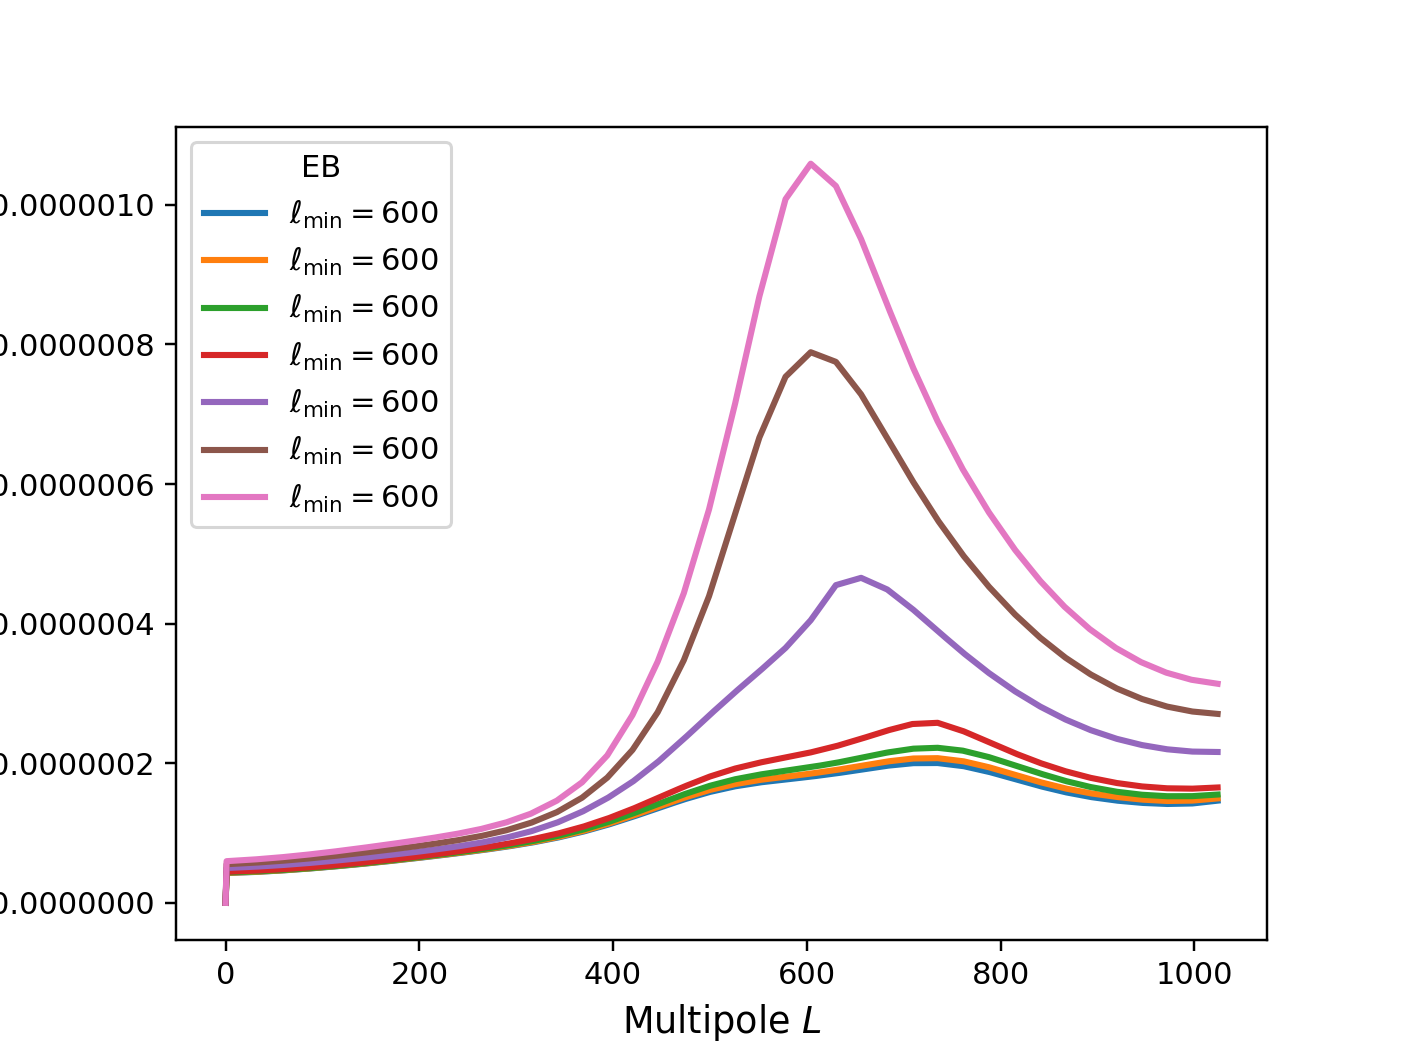

<IPython.core.display.Javascript object>


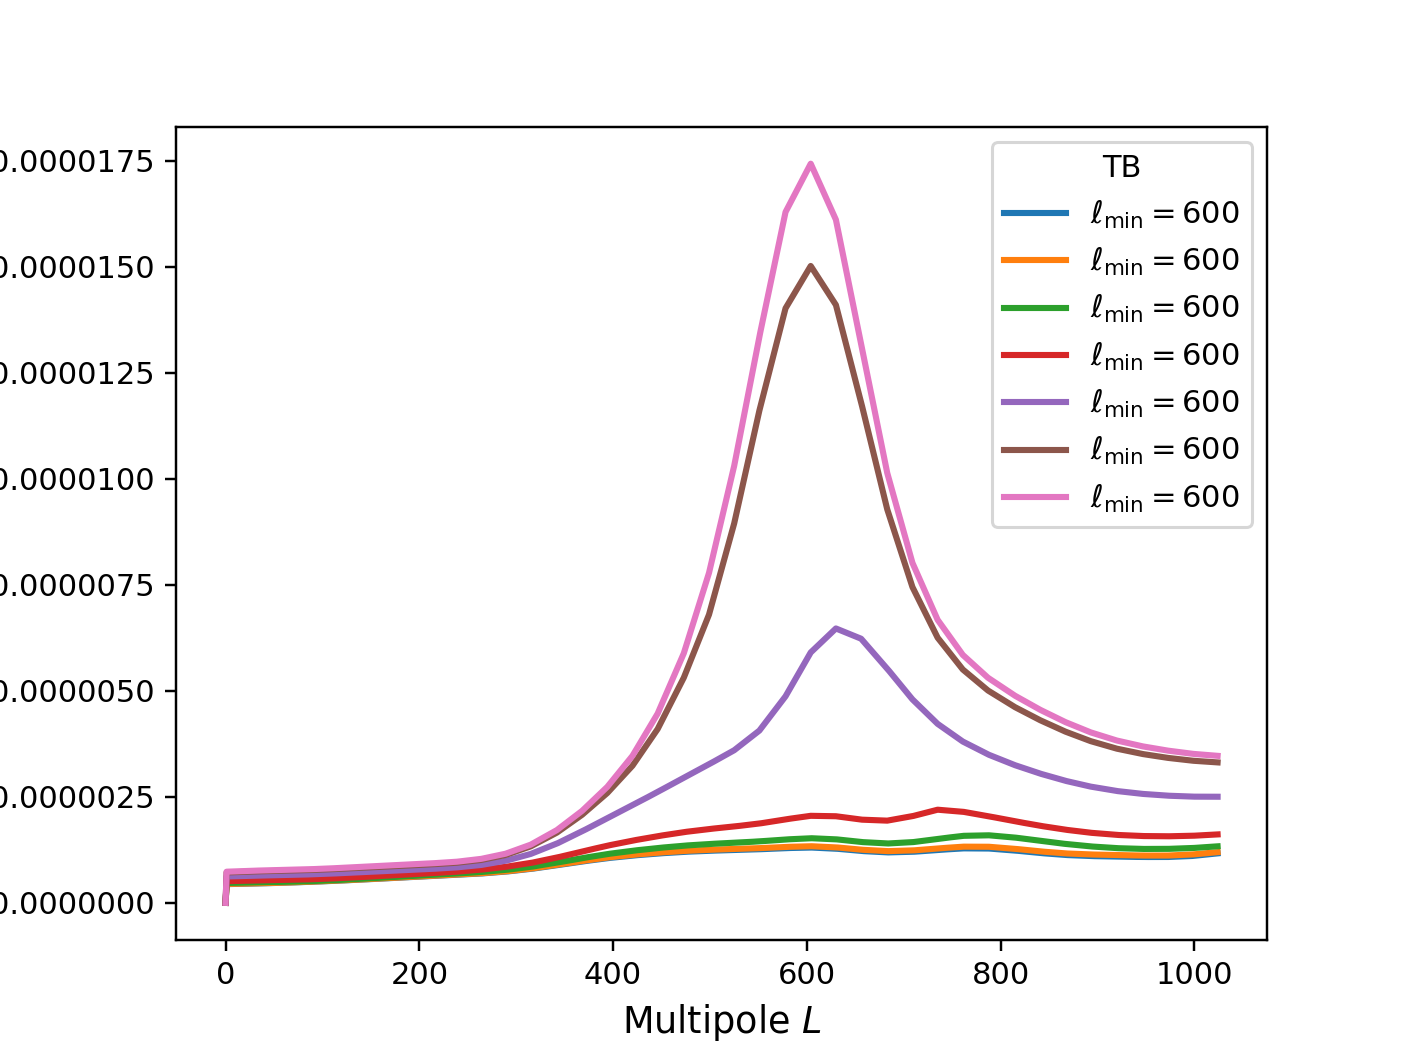

In [15]:
L=np.arange(Lmax+1)
figure()
for temp_lmin in [2,100,200,300,400,500,600]:
    NLeb=calc_eb_rec_noise(clthr[1],clthr[1],clthr[2],temp_lmin,lmax,Lmax)
    plot(L,NLeb,"-",lw=2,label=r"$\ell_{\rm min}=$" + str(lmin))
xlabel("Multipole $L$",fontsize=12)
ylabel("$N_L$",fontsize=12)
legend(loc=0,title="EB")
figname=figpath + "eb_recnoise_fn_of_lmin.pdf"
savefig(figname,bbox_inches="tight")

figure()
for temp_lmin in [2,100,200,300,400,500,600]:
    NLtb=calc_tb_rec_noise(clthr[3],clthr[0],clthr[2],temp_lmin,lmax,Lmax)
    plot(L,NLtb,"-",lw=2,label=r"$\ell_{\rm min}=$" + str(lmin))
xlabel("Multipole $L$",fontsize=12)
ylabel("$N_L$",fontsize=12)
legend(loc=0,title="TB")
figname=figpath + "tb_recnoise_fn_of_lmin.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


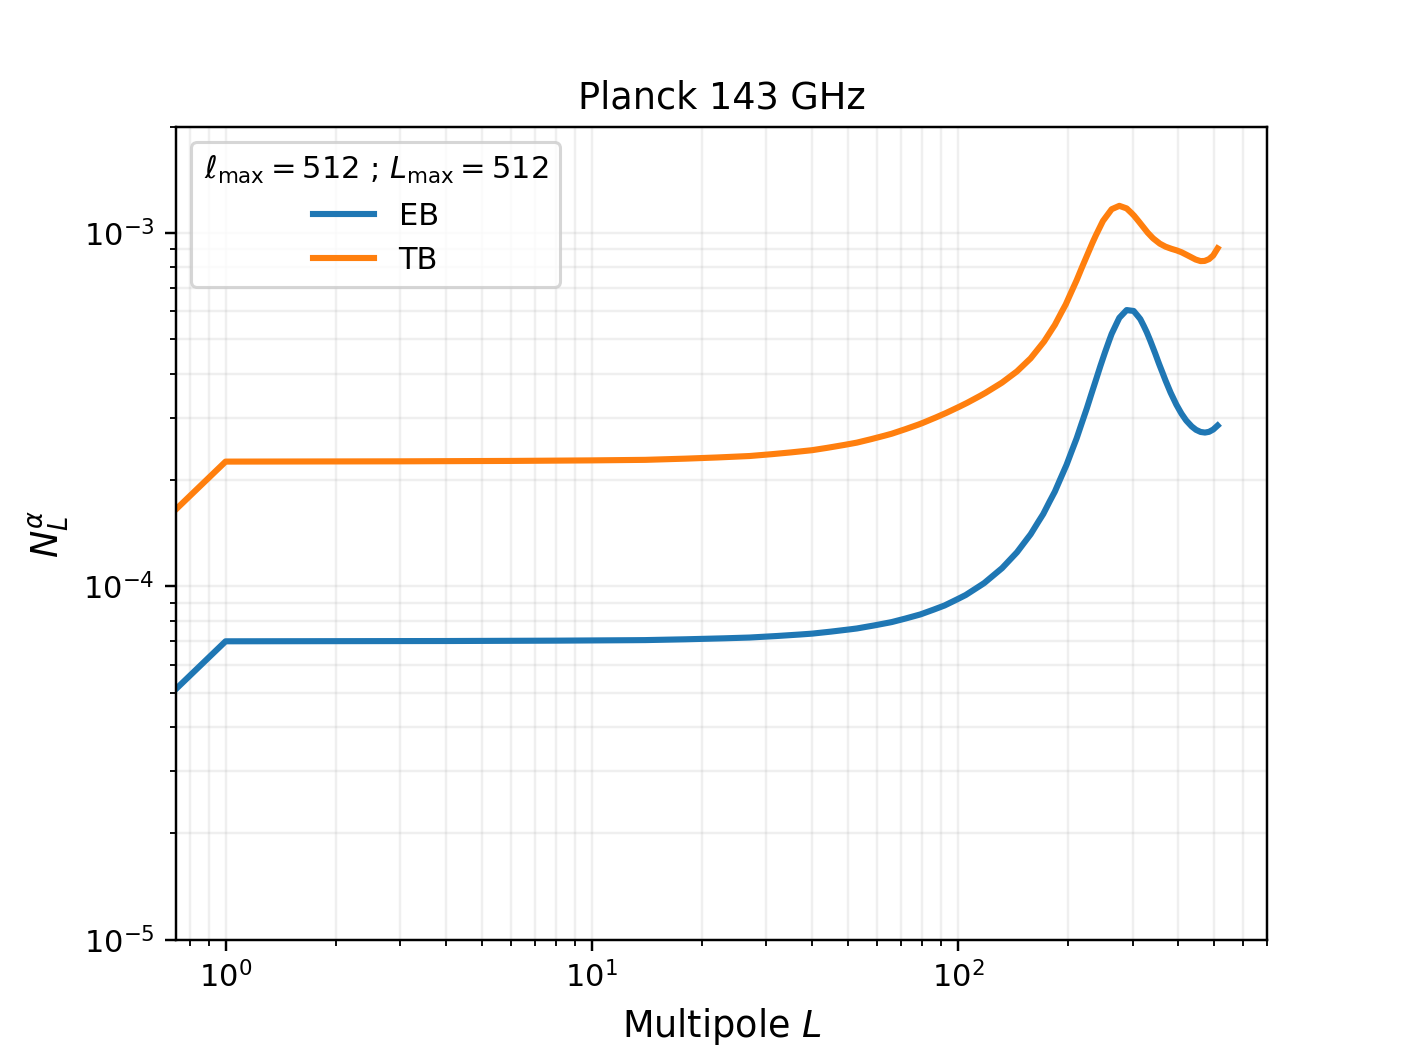

In [80]:
L=np.arange(Lmax+1)
NLeb=calc_eb_rec_noise(clthr[1],clm52[1],clm52[2],lmin,lmax,Lmax)
NLtb=calc_tb_rec_noise(clthr[3],clm52[0],clm52[2],lmin,lmax,Lmax)

figure()
plot(L,NLeb,"-",lw=2,label="EB")
plot(L,NLtb,"-",lw=2,label="TB")
loglog()
ylabel(r"$N^{\alpha}_L$",fontsize=12)
xlabel(r"Multipole $L$",fontsize=12)
grid(which="both",alpha=0.2,linestyle="solid")
legend(loc="upper left",title=r"$\ell_{\rm max}=$" + str(lmax) + " ; " + r"$L_{\rm max}=$"+str(Lmax) )
title("Planck 143 GHz")
ylim(1e-5,2e-3)
# figname=figpath + "eb_vs_tb_recnoise_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
figname=figpath + "eb_vs_tb_recnoise_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".jpeg"
savefig(figname,bbox_inches="tight",dpi=250)

In [58]:
# eb1=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=2)
# eb1.eb_reconstruct()

# eb2=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=200)
# eb2.eb_reconstruct()

# figure()
# plot(eb1.Cl_rec_alpha)
# plot(eb1.N_L)

# figure()
# plot(eb2.Cl_rec_alpha)
# plot(eb2.N_L,"k--")

In [59]:
# tb1=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=2)
# tb1.tb_reconstruct()

# tb2=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=200)
# tb2.tb_reconstruct()

# figure()
# plot(tb1.Cl_rec_alpha)
# plot(tb1.N_L)

# figure()
# plot(tb2.Cl_rec_alpha)
# plot(tb2.N_L,"k--")

In [81]:
eb52=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=lmin)
eb52.eb_reconstruct()

eb62=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask62,ellmin=lmin)
eb62.eb_reconstruct()

eb72=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask72,ellmin=lmin)
eb72.eb_reconstruct()

In [82]:
tb52=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask52,ellmin=lmin)
tb52.tb_reconstruct()

tb62=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask62,ellmin=lmin)
tb62.tb_reconstruct()

tb72=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask72,ellmin=lmin)
tb72.tb_reconstruct()

<IPython.core.display.Javascript object>


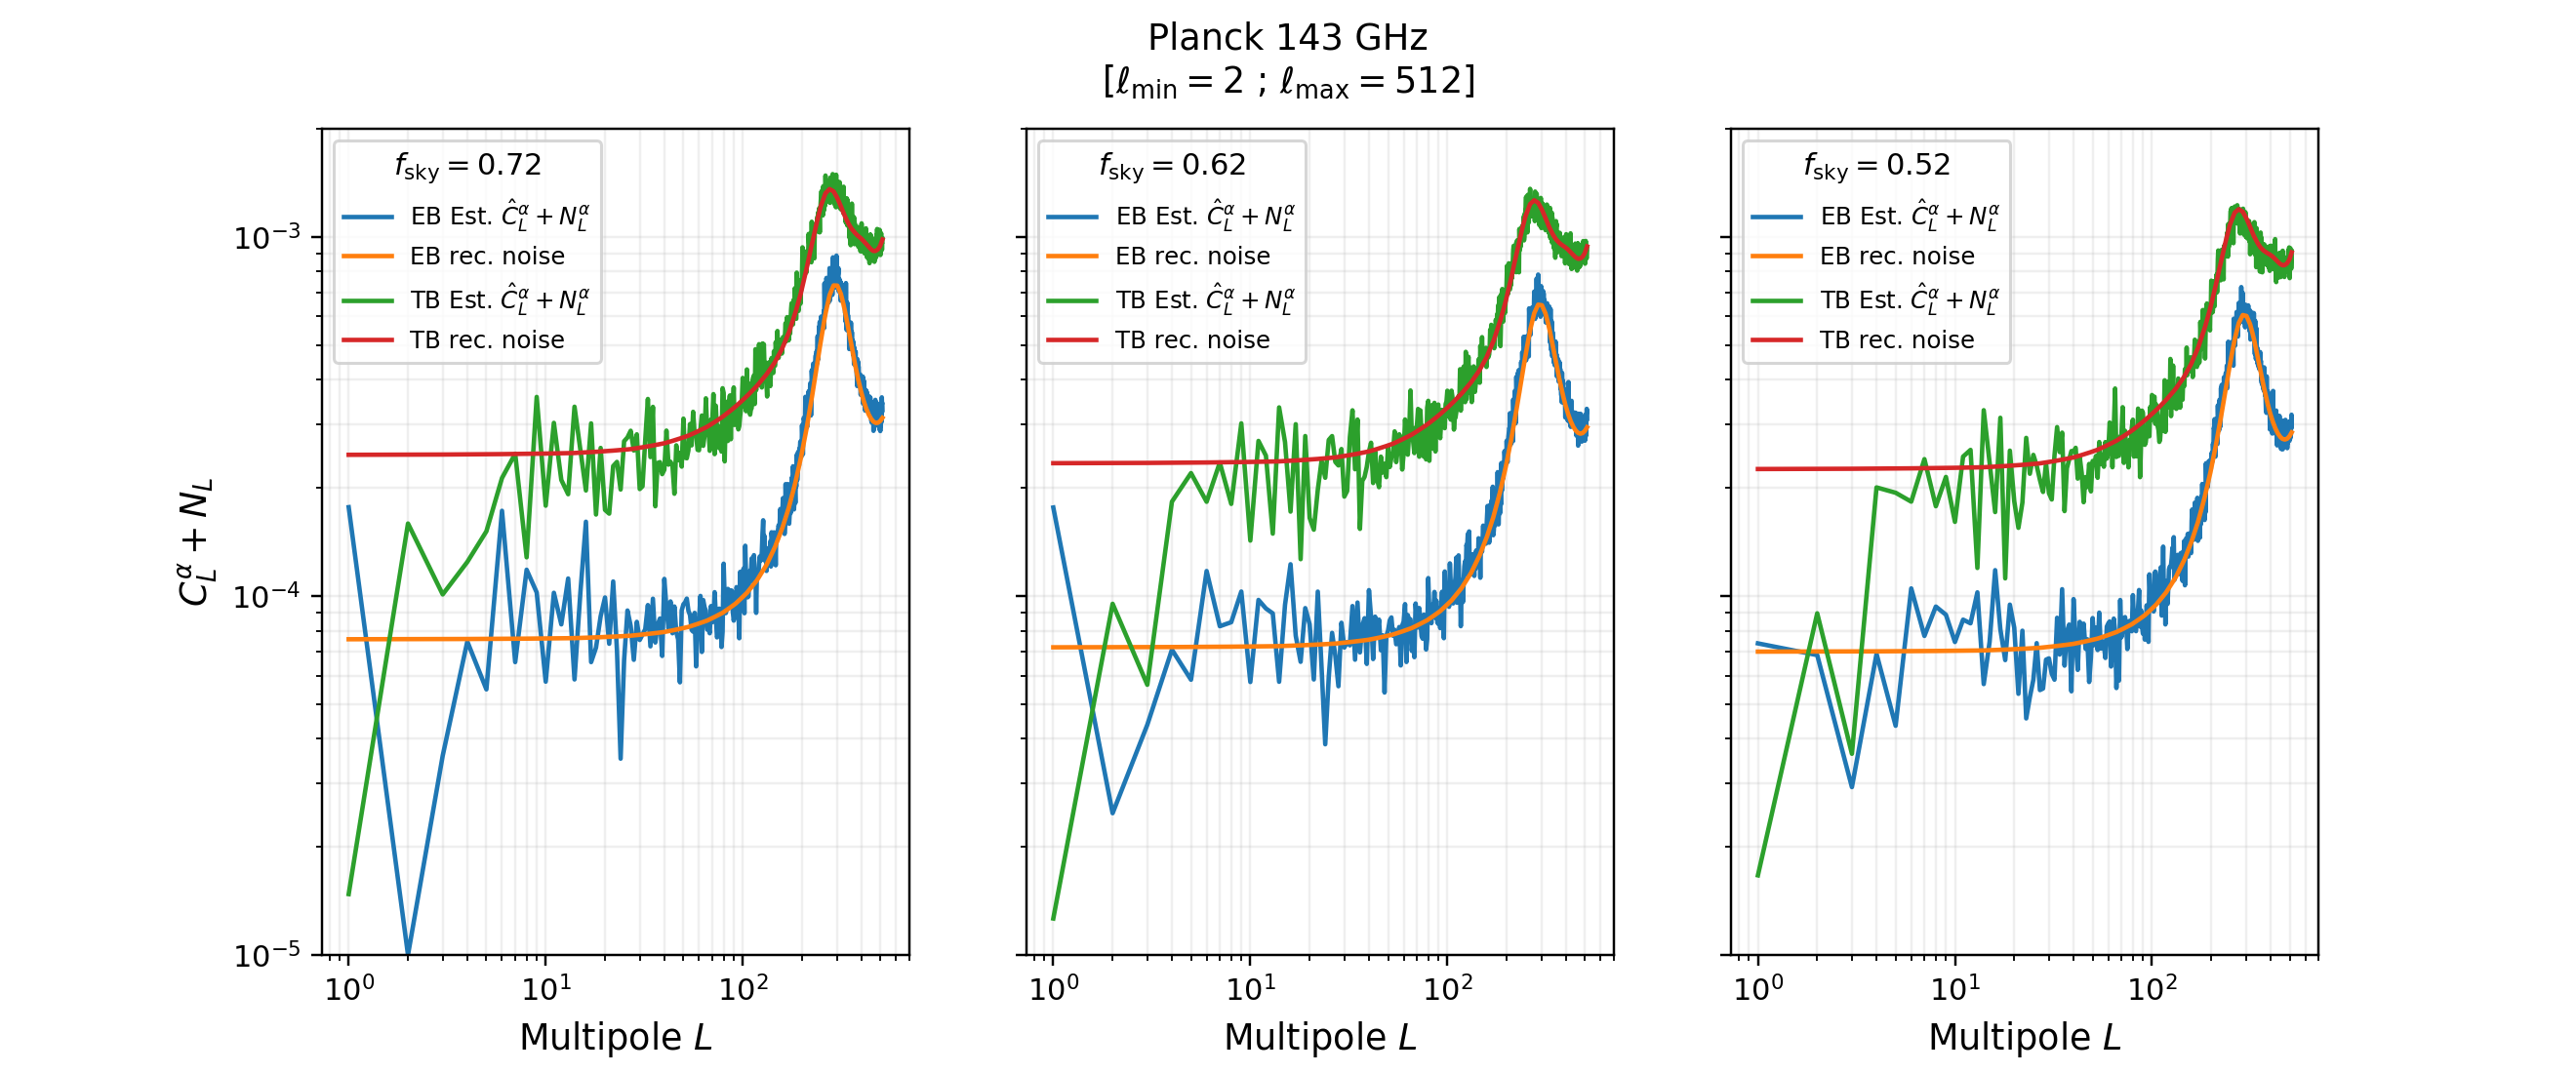

In [83]:
fig,ax=subplots(ncols=3,nrows=1,sharey=True,figsize=[12,5])
L=np.arange(eb52.Lmax+1)
fL=np.ones(eb52.Lmax+1,np.float64)
ax[0].plot(L[1:],fL[1:]*eb72.Cl_rec_alpha[1:],label=r"EB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[0].plot(L[1:],fL[1:]*eb72.N_L[1:],label=r"EB rec. noise")
ax[0].plot(L[1:],fL[1:]*tb72.Cl_rec_alpha[1:],label=r"TB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[0].plot(L[1:],fL[1:]*tb72.N_L[1:],label=r"TB rec. noise")
ax[0].loglog()
ax[0].legend(loc="upper left",title=r"$f_{\rm sky}=$" + str(round(fsky72,2)),fontsize=8)
ax[0].set_xlabel(r"Multipole $L$",fontsize=12)
ax[0].set_ylabel(r"$C^{\alpha}_L + N_{L}$",fontsize=12)
ax[0].grid(alpha=0.2,which="both")
ax[0].set_ylim(1e-5,2e-3)

ax[1].plot(L[1:],fL[1:]*eb62.Cl_rec_alpha[1:],label=r"EB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[1].plot(L[1:],fL[1:]*eb62.N_L[1:],label=r"EB rec. noise")
ax[1].plot(L[1:],fL[1:]*tb62.Cl_rec_alpha[1:],label=r"TB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[1].plot(L[1:],fL[1:]*tb62.N_L[1:],label=r"TB rec. noise")
ax[1].loglog()
ax[1].legend(loc="upper left",title=r"$f_{\rm sky}=$" + str(round(fsky62,2)),fontsize=8)
ax[1].set_xlabel(r"Multipole $L$",fontsize=12)
ax[1].grid(alpha=0.2,which="both")
ax[1].set_ylim(1e-5,2e-3)
# ax[1].set_ylabel(r"$C^{\alpha}_L + N_{L}$",fontsize=12)

ax[2].plot(L[1:],fL[1:]*eb52.Cl_rec_alpha[1:],label=r"EB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[2].plot(L[1:],fL[1:]*eb52.N_L[1:],label=r"EB rec. noise")
ax[2].plot(L[1:],fL[1:]*tb52.Cl_rec_alpha[1:],label=r"TB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
ax[2].plot(L[1:],fL[1:]*tb52.N_L[1:],label=r"TB rec. noise")
ax[2].loglog()
ax[2].legend(loc="upper left",title=r"$f_{\rm sky}=$" + str(round(fsky52,2)),fontsize=8)
ax[2].set_xlabel(r"Multipole $L$",fontsize=12)
ax[2].grid(alpha=0.2,which="both")
ax[2].set_ylim(1e-5,2e-3)
# ax[2].set_ylabel(r"$C^{\alpha}_L + N_{L}$",fontsize=12)

suptitle(r"Planck 143 GHz" "\n" r"[$\ell_{\rm min}=$" + str(lmin) + " ; " + r"$\ell_{\rm max}=$"  + str(lmax) + "]")
figname=figpath + "planck143_eb_tb_reconstructed_alpha_ps_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".jpeg"
savefig(figname,bbox_inches="tight",dpi=250)

<IPython.core.display.Javascript object>


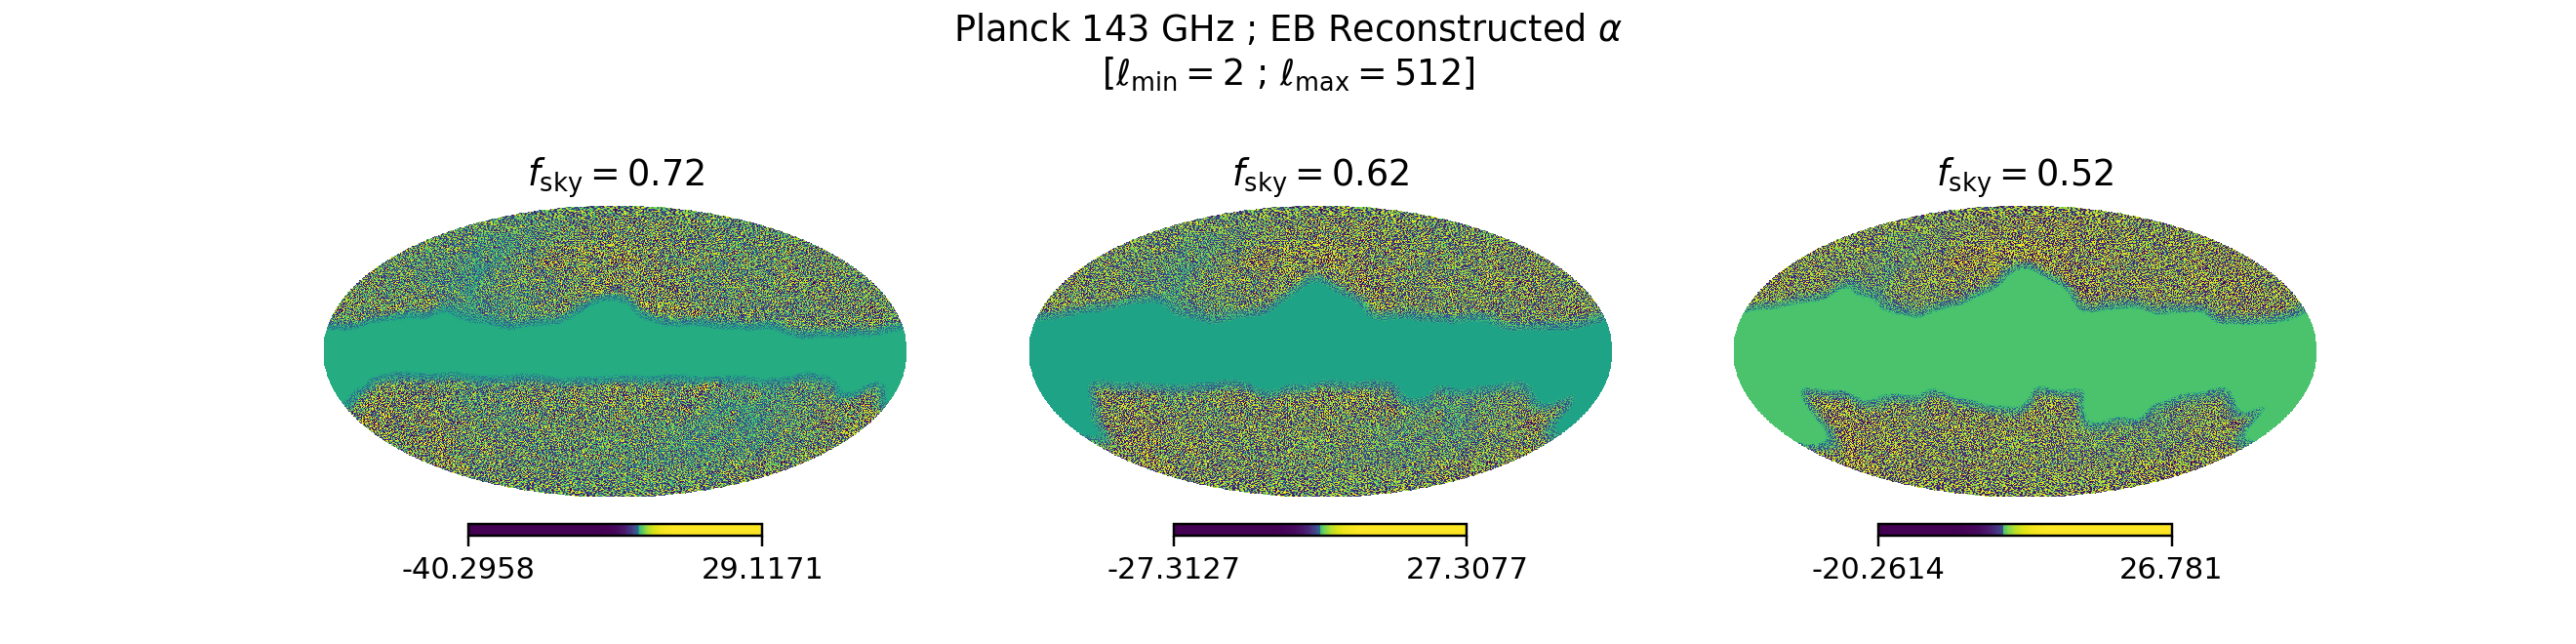

In [84]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=[12,3.])
axes(ax1)
h.mollview(eb72.rec_alpha*mask72,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky72,2)),norm="hist")
axes(ax2)
h.mollview(eb62.rec_alpha*mask62,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky62,2)),norm="hist")
axes(ax3)
h.mollview(eb52.rec_alpha*mask52,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky52,2)),norm="hist")
suptitle(r"Planck 143 GHz ; EB Reconstructed $\alpha$" "\n" r"[$\ell_{\rm min}=$" + str(lmin) + " ; " + r"$\ell_{\rm max}=$"  + str(lmax) + "]")
figname=figpath + "planck143_eb_reconstructed_alpha_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight",dpi=300)

<IPython.core.display.Javascript object>


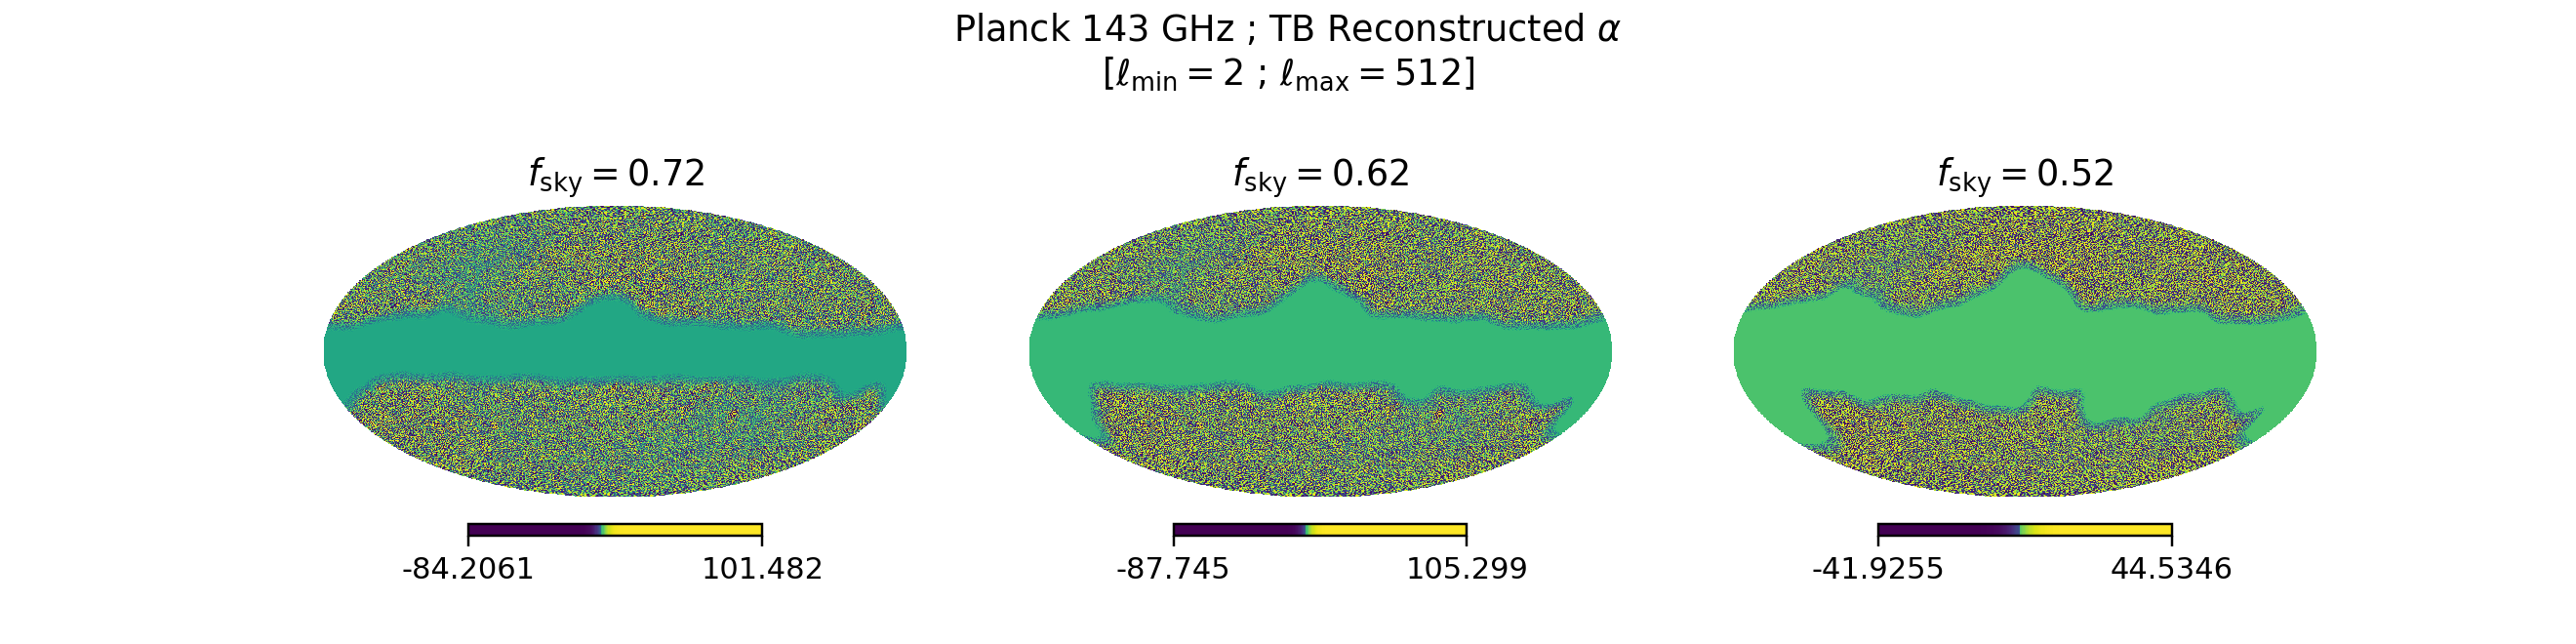

In [85]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3,figsize=[12,3.])
axes(ax1)
h.mollview(tb72.rec_alpha*mask72,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky72,2)),norm="hist")
axes(ax2)
h.mollview(tb62.rec_alpha*mask62,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky62,2)),norm="hist")
axes(ax3)
h.mollview(tb52.rec_alpha*mask52,hold=True,title=r"$f_{\rm sky}=$" + str(round(fsky52,2)),norm="hist")
suptitle(r"Planck 143 GHz ; TB Reconstructed $\alpha$" "\n" r"[$\ell_{\rm min}=$" + str(lmin) + " ; " + r"$\ell_{\rm max}=$"  + str(lmax) + "]")
figname=figpath + "planck143_tb_reconstructed_alpha_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".pdf"
savefig(figname,bbox_inches="tight",dpi=300)

# Birefringence constraints

In [258]:
clthry=np.zeros(Lmax+1,np.float64)
clthry[1:]=1./(L[1:]*(L[1:]+1))

In [259]:
def bire_lkl(A,Clobs,Nl,clthry,fsky):
    L=np.arange(Lmax+1)
    var=(2./((2.*L+1)*fsky))*Nl**2.
    chi2=np.sum((Clobs[1:]-A*clthry[1:])**2/var[1:])
    return chi2

In [260]:
Avals=np.logspace(-5,2,1000)
chi_eb52=np.zeros_like(Avals)
chi_eb62=np.zeros_like(Avals)
chi_eb72=np.zeros_like(Avals)
chi_tb52=np.zeros_like(Avals)
chi_tb62=np.zeros_like(Avals)
chi_tb72=np.zeros_like(Avals)
for i,A in enumerate(Avals):
    chi_eb52[i]=bire_lkl(A,eb52.Cl_rec_alpha,eb52.N_L,clthry,eb52.fsky)
    chi_eb62[i]=bire_lkl(A,eb62.Cl_rec_alpha,eb62.N_L,clthry,eb62.fsky)
    chi_eb72[i]=bire_lkl(A,eb72.Cl_rec_alpha,eb72.N_L,clthry,eb72.fsky)
    chi_tb52[i]=bire_lkl(A,tb52.Cl_rec_alpha,tb52.N_L,clthry,tb52.fsky)
    chi_tb62[i]=bire_lkl(A,tb62.Cl_rec_alpha,tb62.N_L,clthry,tb62.fsky)
    chi_tb72[i]=bire_lkl(A,tb72.Cl_rec_alpha,tb72.N_L,clthry,tb72.fsky)

In [261]:
chi_eb52=chi_eb52/min(chi_eb52)
chi_eb62=chi_eb62/min(chi_eb62)
chi_eb72=chi_eb72/min(chi_eb72)

chi_tb52=chi_tb52/min(chi_tb52)
chi_tb62=chi_tb62/min(chi_tb62)
chi_tb72=chi_tb72/min(chi_tb72)

<IPython.core.display.Javascript object>


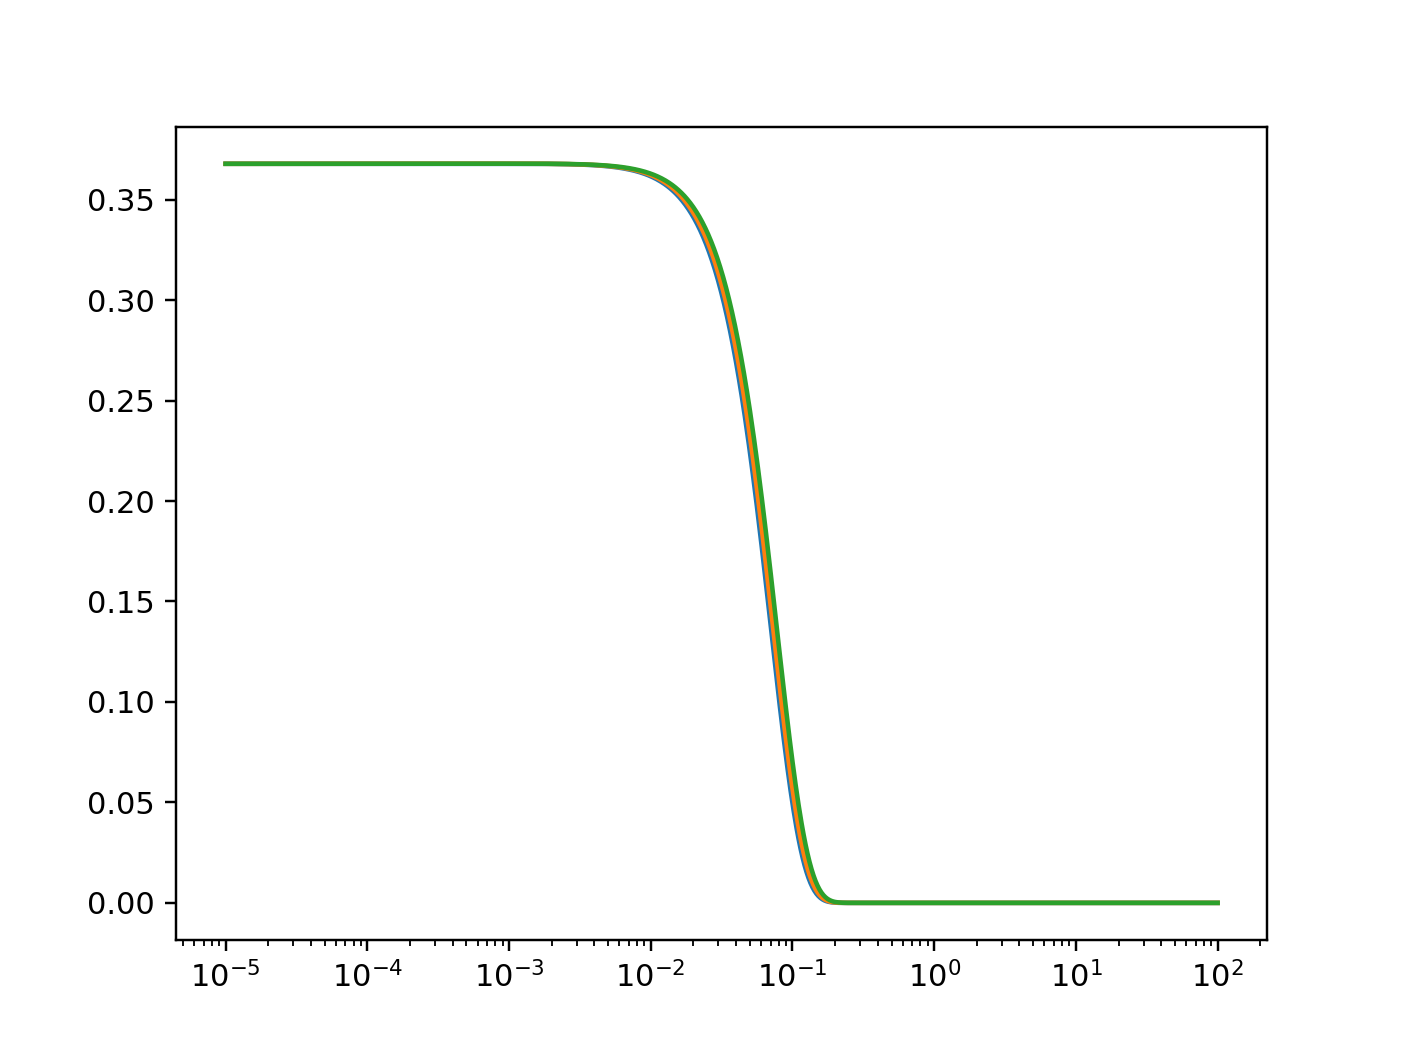

<IPython.core.display.Javascript object>


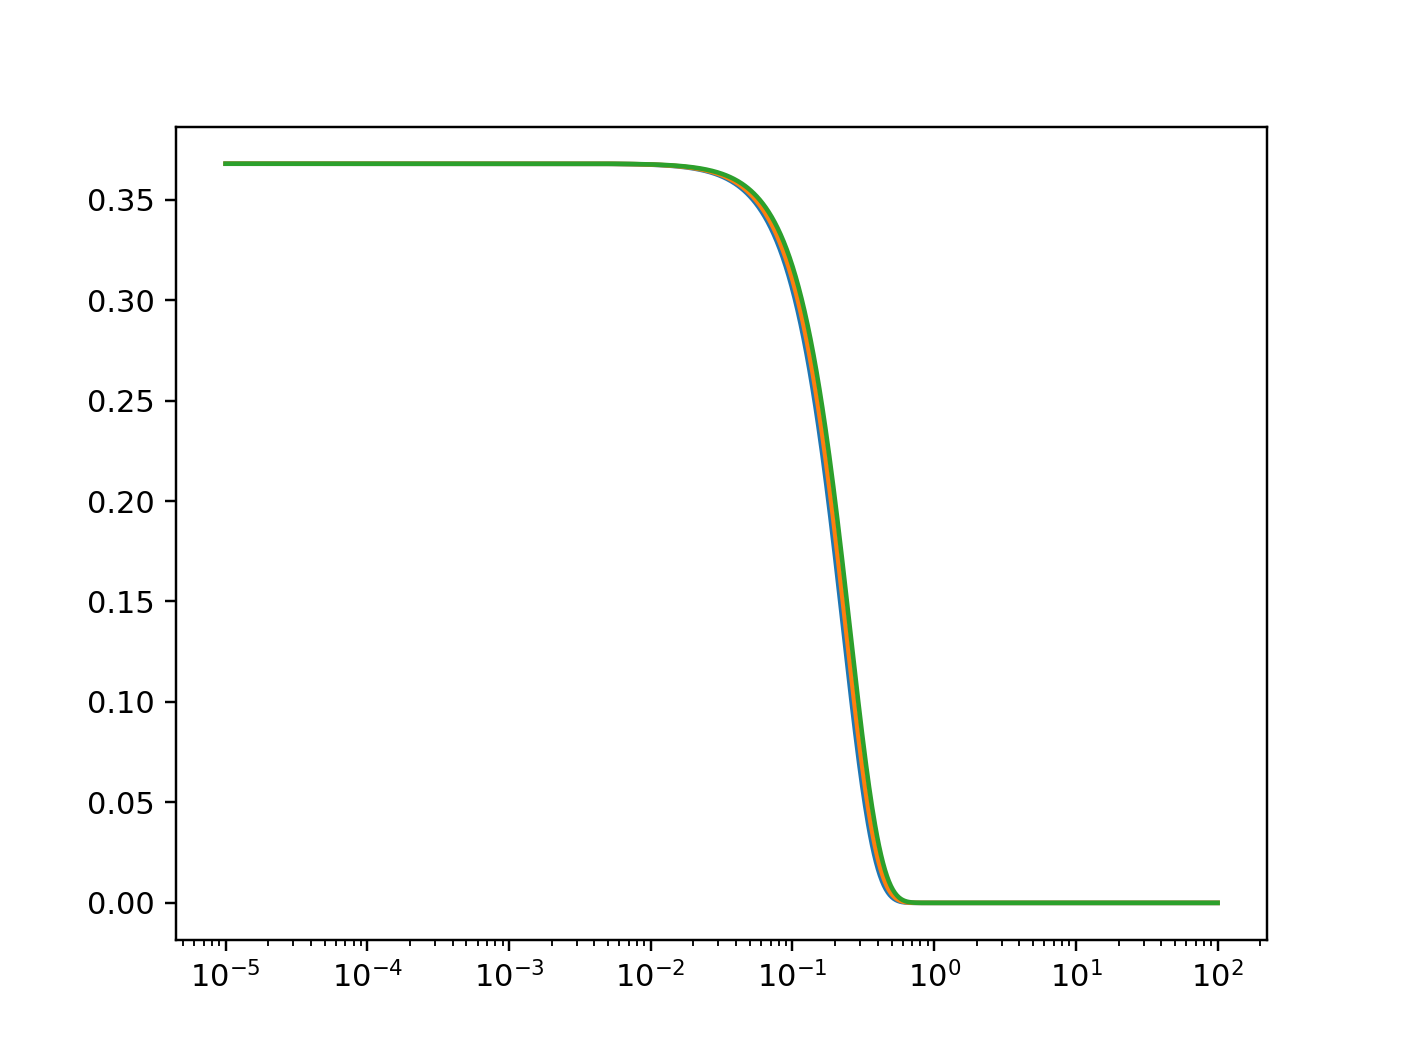

[]

In [262]:
figure()
plot(Avals,exp(-chi_eb52))
plot(Avals,exp(-chi_eb62))
plot(Avals,exp(-chi_eb72))
semilogx()

figure()
plot(Avals,exp(-chi_tb52))
plot(Avals,exp(-chi_tb62))
plot(Avals,exp(-chi_tb72))
semilogx()

<IPython.core.display.Javascript object>


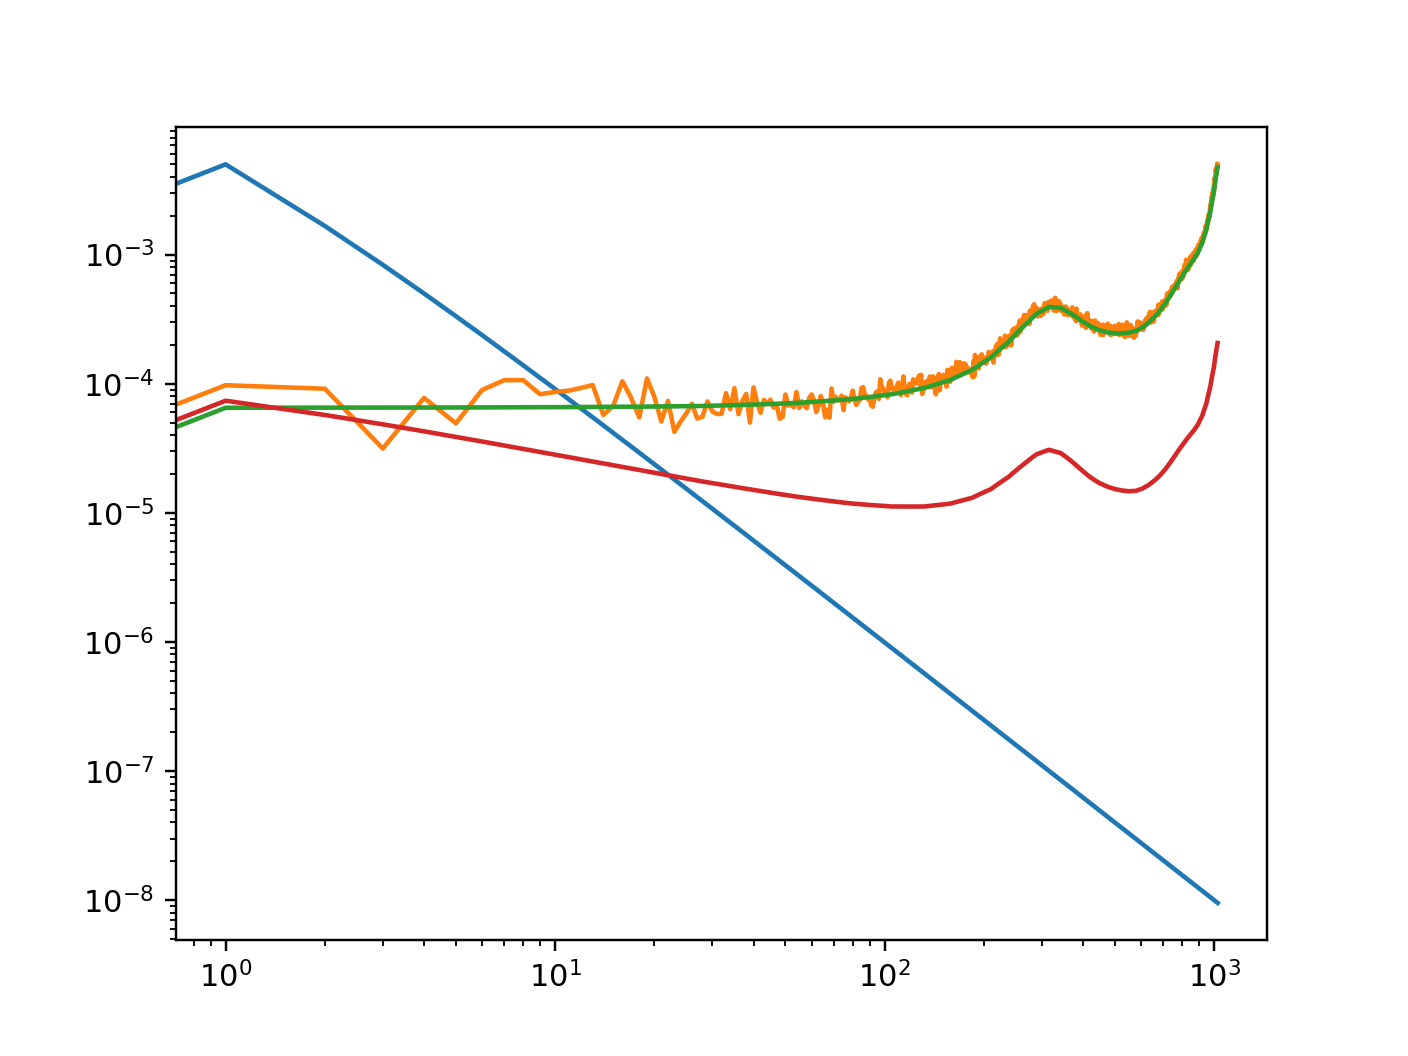

<IPython.core.display.Javascript object>


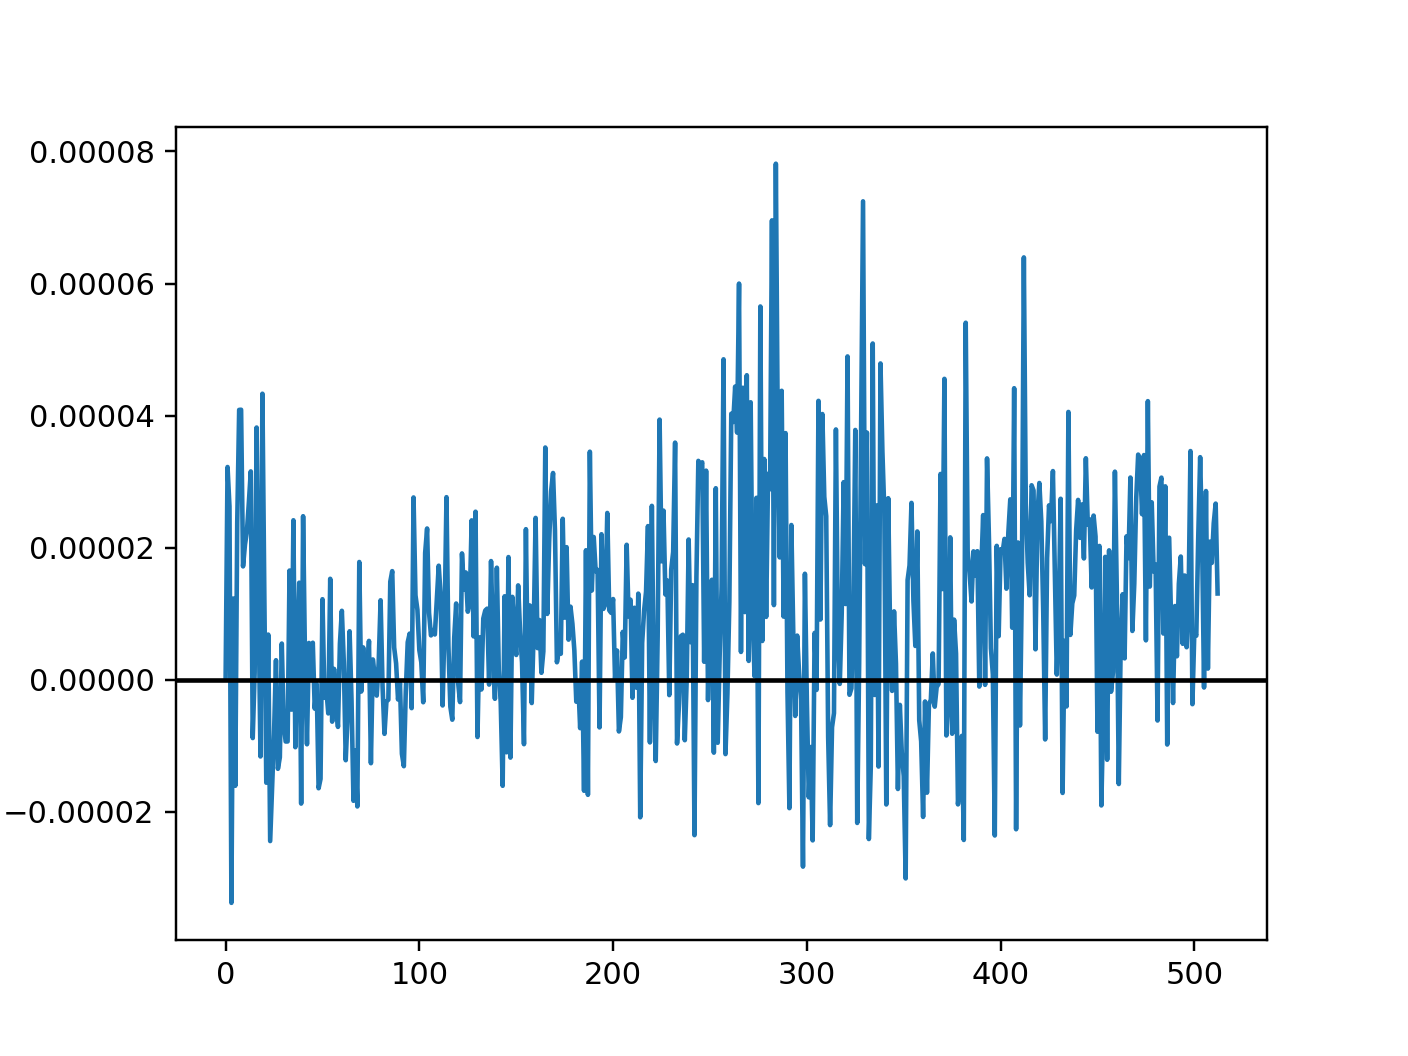

In [257]:
figure()
plot(cl_alpha*1e-2)
plot(eb52.Cl_rec_alpha)
plot(eb52.N_L)
plot(eb52.N_L*np.sqrt(2./((2.*L+1)*eb52.fsky)))
loglog()

figure()
plot(eb52.Cl_rec_alpha[:513]-eb52.N_L[:513])
axhline(0,color="k")